# Coral Paleoclimate Practical #1 - Generating an age Model

This worksheet will go through the basics of coral paleoclimate and uses basic python. We will assume no knowledge of python however there are some basics that will help (these would be resources for fututre!); 

- 10 minutes into pandas - https://pandas.pydata.org/docs/user_guide/10min.html#min
- what is xarray - https://tutorial.xarray.dev/overview/xarray-in-45-min.html
- some great xarray examples - https://docs.xarray.dev/en/stable/gallery.html

Some good paleoclimate specific pages; 
- Pyleoclim - https://pyleoclim-util.readthedocs.io/en/latest/

Other free resources; 
- Earth Lab - https://www.earthdatascience.org/courses/use-data-open-source-python/
- ARC Center for Excellence and climate extremes - https://climate-cms.org/index.html

### In this notebook we will generate an age model for a short coral. 
- This coral is from Mauritius and was collected in 1989. We have given you a short version of the core and we are going to use the raw Sr/Ca results (generated using an ICP-OES here in Bremen) and sea surface temperature from reanalysis datasets to generate an age model. 

### The very first thing that you have to do when using python is to import any package that you need to use. 
- python is basically a shell, you need to tell it what is needed

In [87]:
import pyleoclim as pyleo #this is the paleoclimate python model -- May not use this 
import xarray as xr #xarray is the processing package that helps deal with large datasets (often gridded data)
import pandas as pd #this is the main python package that deals with open source data analysis and manipulation


import sys #this is a module that provides various functions and variables
import numpy as np

from netCDF4 import num2date
import cftime #this is a time related pacakge

# this is all for plotting...
import matplotlib as mpl #mapping and plotting package
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy #this is another mapping package

from scipy import interpolate

import datetime
from datetime import date, datetime, timedelta   # to convert "days since XXX" to date

### Now we import the excel sheet that contains the coral information. 

- it is in the same folder as this sheet, so we just need to call the name of it using a 'read_excel' command. This is part of one of the python packages called pandas. 

In [70]:
# this reads the excel sheet, and puts it into a pandas dataframe.

# we always have to call it something useful, the name of the coral is MAU2
MAU2_SrCa = pd.read_excel('MAU2_shorted_for_prac.xlsx') 
MAU2_SrCa

,ID,SampleNo,depth,SrCa
0,Mau-2/,1,0.000,NaN
1,Mau-2/,2,0.175,9.323335
2,Mau-2/,3,0.325,9.164798
3,Mau-2/,4,0.475,9.061630
4,Mau-2/,5,0.625,9.010160
...,...,...,...,...
221,Mau-2/,222,35.050,9.224453
222,Mau-2/,223,35.175,9.045796
223,Mau-2/,224,35.325,8.977354
224,Mau-2/,225,35.475,9.034190


### We can use this pandas dataframe, but the best way to deal with climate data is to convert it into a format called netcdf. 

- to use netcdf we can use a python package called xarray. This will also us to execute common stats if we want

In [71]:
# this generates that xarray dataset, with the Coral SrCa, and then creates a variable called depth
MAU2_SrCa_xr = xr.Dataset({'SrCa':MAU2_SrCa.SrCa},
                     attrs=dict(description="MAU1_SrCa_Corrected_SrCa"),)

MAU2_SrCa_xr['depth']=MAU2_SrCa.depth
MAU2_SrCa_xr

<xarray.Dataset>
Dimensions:  (dim_0: 226)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 ... 218 219 220 221 222 223 224 225
Data variables:
    SrCa     (dim_0) float64 nan 9.323 9.165 9.062 ... 9.046 8.977 9.034 9.083
    depth    (dim_0) float64 0.0 0.175 0.325 0.475 ... 35.17 35.32 35.47 35.67
Attributes:
    description:  MAU1_SrCa_Corrected_SrCa

### We generate age models based on the maximum (which is related to minimum temperature) value of Sr/Ca for each month. That means we need to find this value.

In [72]:
# We can used a function called 'find_peaks' which finds the largest value with some conditions.

# We set the distance at at least 5 (because the data is bimonthly, 6 samples a year), and above a certain value
peaks_low_temp, _ = find_peaks(MAU2_SrCa_xr.SrCa, distance=5, height=9.2)

# We can do the same with the smallest peaks
peaks_high_temp, _ = find_peaks(-MAU2_SrCa_xr.SrCa, distance=5)


Text(0.5, 1.0, 'MAU2 Sr/Ca Raw Data')

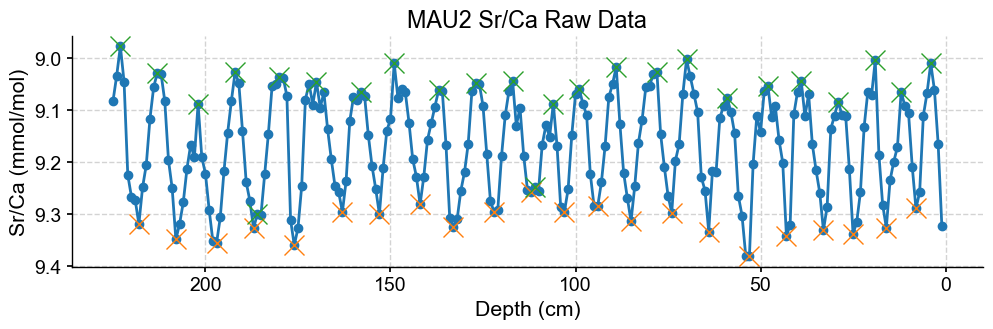

In [73]:
## Now lets plot this! 

fig = plt.figure(figsize=(40, 3)) #this sets up a figure


ax = fig.add_subplot(1, 3, 1) # this sets up a subplot, which we dont use here but is good for future!

ax.plot(MAU2_SrCa_xr.SrCa, **{ 'marker': 'o'}) #this plots the SrCa by the index. It also plots every point with a dot

#this will plot each peak we found in the last cell, with information about the point. 
ax.plot(peaks_high, MAU2_SrCa_xr.SrCa[peaks_low_temp], "x", markersize = 14) 
ax.plot(peaks_low, MAU2_SrCa_xr.SrCa[peaks_high_temp], "x", markersize = 14)

#we invert this so that warm is up on the graph
plt.gca().invert_yaxis()

#we are just inverting the x-axis because its more normal to look at these datasets with the youngest on the right
plt.gca().invert_xaxis() 

ax.set_ylabel('Sr/Ca (mmol/mol)', color= 'black') # this sets the y-label
ax.set_xlabel('Depth (cm)', color= 'black') #this sets the x-label
ax.set_title('MAU2 Sr/Ca Raw Data') #this sets the title



### For this location we just want to look at the low temperature (which are the maximum values) because there is less variability in the minimum temperature values at Mauritius

- this is what we called peaks_low_temps in the last cell, so we can put this into its own dataframe

In [74]:
#this creates a dataframe that consists of the depth values 
#of the low_temperature peaks, We want to know the depth markers rather than the value of the points

#the code 'MAU2_SrCa_xr.depth[peaks_low_temp]' uses the index we develop in the peaks_low_temp and finds that depth value of each in the xarray
df = pd.DataFrame({'depth_markers':MAU2_SrCa_xr.depth[peaks_low_temp]})

#this just adds a 0 index point for the top value of the coral
df.loc[-1] = [0]

df.index = df.index + 1  # shifting index down one to shift it down
df.sort_index(inplace=True) #and then sorting the index so it runs from 0 to 22

df #and we can just print it out

,depth_markers
0,0.000
1,1.300
2,2.600
3,4.100
4,5.350
5,6.950
6,8.225
7,10.050
8,11.750
9,13.475


#### Now we need to import the SST dataset

- The dataset is called ERSST_MAU2de and contains SST values for Mauritius for the same length as the coral piece

In [75]:
ERSST_short = xr.open_dataset('ERSST_MAU2de.nc') # this is how we open a netcdf4 file into an xarray dataset 

ERSST_short #and now we can just print it out here

<xarray.Dataset>
Dimensions:  (time: 138)
Coordinates:
  * time     (time) float64 1.967e+03 1.967e+03 1.967e+03 ... 1.99e+03 1.99e+03
Data variables:
    sst      (time) float32 ...

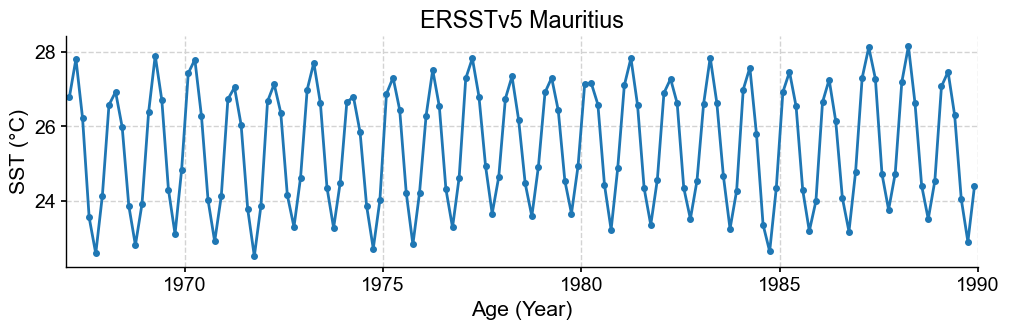

In [50]:
## Now lets plot this! 
fig = plt.figure(figsize=(40, 3))#this sets up a figure

ax = fig.add_subplot(1, 3, 1)# this sets up a subplot, which we dont use here but is good for future!

ax.plot(ERSST_short.time,ERSST_short.sst, **{ 'marker': 'o'},markersize = 4)#this plots the SST by the time. It also plots every point with a dot

#we are just inverting the x-axis because its more normal to look at these datasets with the youngest on the right
plt.gca().invert_xaxis()

ax.set_ylabel('SST (°C)', color= 'black') # this sets the y-label
ax.set_xlabel('Age (Year)', color= 'black') #this sets the x-label
ax.set_title('ERSSTv5 Mauritius') #this sets the title
ax.set_xlim([1967,1990])



We want to do the same thing to the SST that we did to the coral dataset!

- find the peaks and align the datasets

In [89]:
# We can used a function called 'find_peaks' which finds the largest value with some conditions.

# We set the distance at at least 4 (because the data is bimonthly, 6 samples a year), and above a certain value
peaks_highERSST_short, _ = find_peaks(ERSST_short.sst, distance=5)
peaks_lowERSST_short, _ = find_peaks(-ERSST_short.sst, distance=5)

Text(0.5, 1.0, 'ERSSTv5 Mauritius')

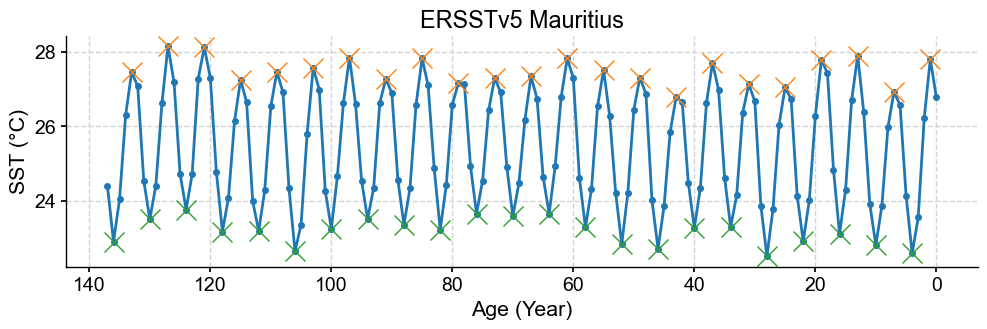

In [90]:
## Now lets plot this! 
fig = plt.figure(figsize=(40, 3))#this sets up a figure

ax = fig.add_subplot(1, 3, 1)# this sets up a subplot, which we dont use here but is good for future!

ax.plot(ERSST_short.sst, **{ 'marker': 'o'},markersize = 4)#this plots the SST by the time. It also plots every point with a dot

ax.plot(peaks_highERSST_short, ERSST_short.sst[peaks_highERSST_short], "x", markersize = 14)
ax.plot(peaks_lowERSST_short, ERSST_short.sst[peaks_lowERSST_short], "x", markersize = 14)

#we are just inverting the x-axis because its more normal to look at these datasets with the youngest on the right
plt.gca().invert_xaxis()

ax.set_ylabel('SST (°C)', color= 'black') # this sets the y-label
ax.set_xlabel('Age (Year)', color= 'black') #this sets the x-label
ax.set_title('ERSSTv5 Mauritius') #this sets the title
# ax.set_xlim([1967,1990])



#### Now we have this we dataset we can put it into a dataframe called Date_markers

In [91]:
Date_markers = ERSST_short.sst[peaks_lowERSST_short] # this is similar to what we did before

# the next bit will just invert the date so that it is the same as the coral
Date_markers = Date_markers.reindex(time=list(reversed(Date_markers.time)))
Date_markers

<xarray.DataArray 'sst' (time: 23)>
array([22.903894, 23.511616, 23.760345, 23.176525, 23.190426, 22.643353,
       23.249966, 23.51586 , 23.35643 , 23.2269  , 23.659096, 23.58695 ,
       23.656586, 23.287647, 22.832863, 22.719835, 23.273624, 23.300447,
       22.514334, 22.911118, 23.109379, 22.810677, 22.58738 ], dtype=float32)
Coordinates:
  * time     (time) float64 1.99e+03 1.989e+03 1.988e+03 ... 1.969e+03 1.968e+03

In [92]:
#finally we can put both of these in the same pandas dataframe
df['date_markers'] = Date_markers.time
df

,depth_markers,date_markers
0,0.000,1989.75
1,1.300,1988.75
2,2.600,1987.75
3,4.100,1986.75
4,5.350,1985.75
5,6.950,1984.75
6,8.225,1983.75
7,10.050,1982.75
8,11.750,1981.75
9,13.475,1980.75


### Now that we have these depth and date markers we can interpolate our dataset along a date.

- first thing is we have to create a date xarray, which is monthly spaced (in this case bi-monthly) and then we can linearlly interpolate along this. 

- We know the top date of the coral, as we know when the alive coral was collected. This is August of 1989, we also know how many years there were (22 years) because of the banding.

- So if this coral is bimonthly resolution, and 22 years there has to be at least 132 bimonthly samples. The coral isn't exactly 22 years so we make the age data array slightly longer.

In [94]:
#creating the depth age vs age, this is a linear data array between the two values
Datenew_Mau2 = np.linspace(1968-9/12, 1990-3/12, 136) 

Datenew_Mau2

array([1967.25      , 1967.41666667, 1967.58333333, 1967.75      ,
       1967.91666667, 1968.08333333, 1968.25      , 1968.41666667,
       1968.58333333, 1968.75      , 1968.91666667, 1969.08333333,
       1969.25      , 1969.41666667, 1969.58333333, 1969.75      ,
       1969.91666667, 1970.08333333, 1970.25      , 1970.41666667,
       1970.58333333, 1970.75      , 1970.91666667, 1971.08333333,
       1971.25      , 1971.41666667, 1971.58333333, 1971.75      ,
       1971.91666667, 1972.08333333, 1972.25      , 1972.41666667,
       1972.58333333, 1972.75      , 1972.91666667, 1973.08333333,
       1973.25      , 1973.41666667, 1973.58333333, 1973.75      ,
       1973.91666667, 1974.08333333, 1974.25      , 1974.41666667,
       1974.58333333, 1974.75      , 1974.91666667, 1975.08333333,
       1975.25      , 1975.41666667, 1975.58333333, 1975.75      ,
       1975.91666667, 1976.08333333, 1976.25      , 1976.41666667,
       1976.58333333, 1976.75      , 1976.91666667, 1977.08333

We can use a function from scipy called interpolate which will linearly interpolate a date to the depth of each coral sample, meaning we will have a date value for every depth. 

- For this we use the depth markers, the date markers and finally the dpeth of the coral from the original xarray dataset

In [96]:
#interpolates the age to the linear portion of the data, this creates a date for each data point. 
f = interpolate.interp1d(df.depth_markers,df.date_markers,fill_value="extrapolate")(MAU2_SrCa.depth) 

Now we can use this f dataset, where there is a date for each sample to interpolate into a monthly dataset, to create the monthly dataset. 

In [98]:
# interpolating the raw values of SrCa into the monthly dates
monthlySr_MAU2 = interpolate.interp1d(f,MAU2_SrCa.SrCa)(Datenew_Mau2) 

monthlySr_MAU2

array([9.02471767, 9.05770635, 9.26834325, 9.31880843, 9.21721158,
       9.08468362, 9.02788477, 9.05949996, 9.22017832, 9.34844741,
       9.29321369, 9.18688253, 9.13967281, 9.19778009, 9.29523911,
       9.35501281, 9.24895401, 9.12290641, 9.03113275, 9.10905902,
       9.25116094, 9.32706459, 9.30026484, 9.22669534, 9.09184297,
       9.04651089, 9.08059915, 9.35931815, 9.25945907, 9.04947278,
       9.06228012, 9.11291397, 9.23721777, 9.29570452, 9.13610273,
       9.07814571, 9.0681918 , 9.1394848 , 9.23051071, 9.29979418,
       9.15501821, 9.02794467, 9.0640609 , 9.09895831, 9.20611827,
       9.28104728, 9.19049851, 9.12385296, 9.07513225, 9.06331398,
       9.20953371, 9.32513596, 9.25259023, 9.17242182, 9.05395042,
       9.06759343, 9.20361881, 9.29638319, 9.21574204, 9.0947696 ,
       9.04552977, 9.10711684, 9.20474174, 9.2574487 , 9.25133537,
       9.17890385, 9.1347796 , 9.09699464, 9.22766549, 9.29495945,
       9.19717546, 9.07586565, 9.07375285, 9.1362588 , 9.26314

In [104]:
# Now we can just put this into a Dataset!
MAU2_SrCa_monthly = xr.Dataset({'SrCa':(['time'],monthlySr_MAU2)},
                     attrs=dict(description="MAU1_monthly_interpolated_SrCa"),)

MAU2_SrCa_monthly['time']=Datenew_Mau2
MAU2_SrCa_monthly

<xarray.Dataset>
Dimensions:  (time: 136)
Coordinates:
  * time     (time) float64 1.967e+03 1.967e+03 1.968e+03 ... 1.99e+03 1.99e+03
Data variables:
    SrCa     (time) float64 9.025 9.058 9.268 9.319 ... 9.018 9.09 9.279 nan
Attributes:
    description:  MAU1_monthly_interpolated_SrCa

Text(0.5, 1.0, 'MAU2 Sr/Ca Bi-monthly Interpolated')

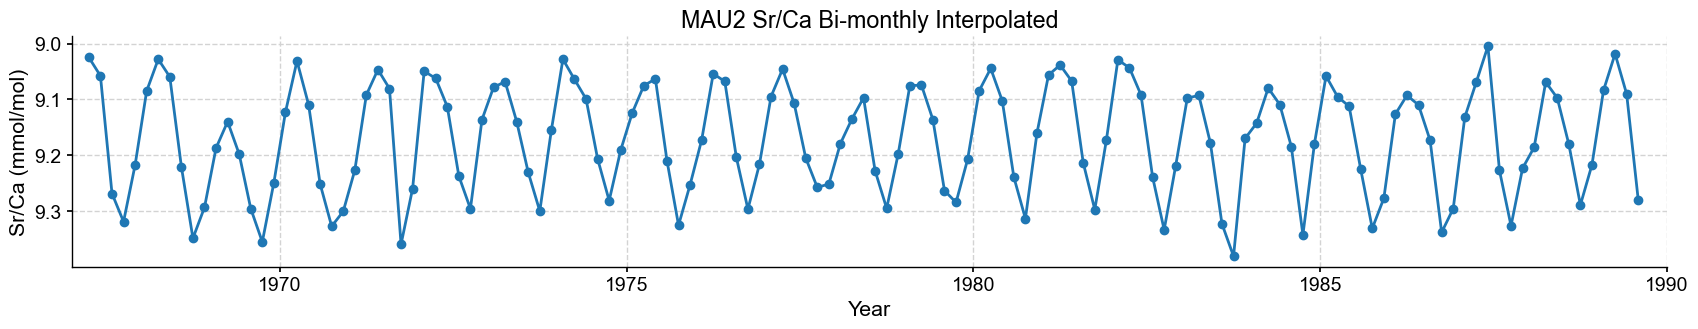

In [103]:
# And finally we can plot this! 
fig = plt.figure(figsize=(70, 3)) #this sets up a figure

ax = fig.add_subplot(1, 3, 1) # this sets up a subplot, which we dont use here but is good for future!

#this plots the Sr/Ca by the new monthly age model. It also plots every point with a dot
ax.plot(MAU2_SrCa_monthly.time,MAU2_SrCa_monthly.SrCa,'-', **{ 'marker': 'o'})

#we are just inverting the x-axis because its more normal to look at these datasets with the youngest on the right
plt.gca().invert_yaxis()
ax.set_xlim([1967,1990])

ax.set_ylabel('Sr/Ca (mmol/mol)', color= 'black') # this sets the y-label
ax.set_xlabel('Year', color= 'black') #this sets the x-label
ax.set_title('MAU2 Sr/Ca Bi-monthly Interpolated') #this sets the title
